# Facial Emotion Recogination

### import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime

import matplotlib.pyplot as plt

import seaborn as sns
import tensorflow as tf
import keras
from keras import backend as K
from keras import regularizers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

from keras.models import Model, load_model
from keras.applications import MobileNetV2


Using TensorFlow backend.


# Importing Dataset

In [2]:
train_dir = "../data/facial_expressions/train/" #path to the training images
test_dir  = "../data/facial_expressions/test/"   #path to the  testing images

In [3]:
IMG_SIZE = 48 #original size of the image in FER dataset
BATCH_SIZE = 64
NUM_EPOCHS = 60

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

        sad  disgust  neutral  angry  happy  fear  surprise
train  4830      436     4965   3995   7215  4097      3171
       sad  disgust  neutral  angry  happy  fear  surprise
test  1247      111     1233    958   1774  1024       831


### PLot of number of images in training set

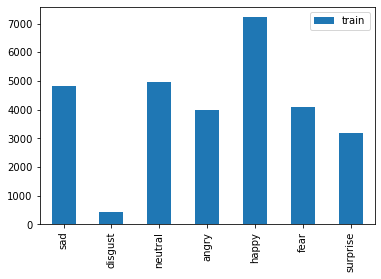

In [4]:
train_count.transpose().plot(kind='bar')

### PLot of number of images in test set

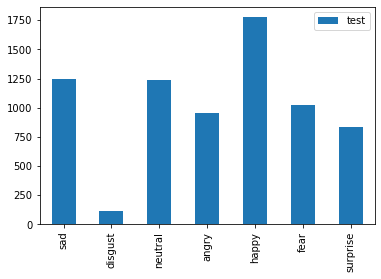

In [5]:
test_count.transpose().plot(kind='bar')

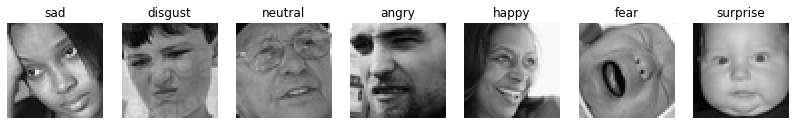

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

### Creating Training and test sets

In [7]:
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""
"""
"""
train_datagen = ImageDataGenerator(rescale=1./255,  #scale image to 0 or 1
                                   #rotation_range = 25,
                                         #width_shift_range = 0.1,
                                         #height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         #vertical_flip=True,
                                         zoom_range = 0.2,
                                         fill_mode="nearest",
                                         validation_split = 0.2
                                        )

valid_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip=True, vertical_flip=False)


In [8]:
"""
Applying data augmentation to the images as we read 
them from their respectivve directories

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). 
The training set consists of 28,709 examples and the public test set consists of 7178  examples.
"""



training_set = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    batch_size = BATCH_SIZE,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training", # set as training data
                                                     shuffle=True
                                                   )

test_set = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    batch_size = BATCH_SIZE,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "validation", # set as validation data
                                                    shuffle=True
                                                   )

valid_set = valid_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (IMG_SIZE, IMG_SIZE),
                                                              batch_size = BATCH_SIZE,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              shuffle=True
                                                             )
                                        

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [10]:
valid_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [11]:
"""
lets write our model
"""


model = Sequential()

model.add(SeparableConv2D(32, kernel_size=(3,3), padding="same",  activation='relu', input_shape=(48, 48,1)))
model.add(SeparableConv2D(64, (3,3), padding="same",  activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(128, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(SeparableConv2D(256, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(SeparableConv2D(512, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(SeparableConv2D(512, (3,3), padding="same",  activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 
model.add(Dense(1024, activation = 'relu'))
# model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax')) #facial expression have 7 classes

model.compile(
    loss="categorical_crossentropy", 
    optimizer = Adam(lr=0.0001, decay=1e-6),
    metrics=['accuracy']
  )


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 48, 48, 32)        73        
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 48, 48, 64)        2400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 24, 24, 128)       8896      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 24, 24, 256)       34176     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 256)       1024      
__________

### Callbacks Function

In [13]:
chk_path = 'facial_expressions.h5'
log_dir = "checkpoint/log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

### Training Model

In [14]:

steps_per_epoch = training_set.samples // training_set.batch_size
valid_steps = valid_set.samples // valid_set.batch_size

history = model.fit_generator(training_set,
                 validation_data=valid_set,
                 epochs=NUM_EPOCHS,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=valid_steps,
                 callbacks=callbacks)

Epoch 1/60
358/358 [==============================] - 18s 51ms/step - loss: 1.6829 - acc: 0.3664 - val_loss: 1.5393 - val_acc: 0.4177

Epoch 00001: val_loss improved from inf to 1.53930, saving model to facial_expressions.h5
Epoch 2/60
358/358 [==============================] - 16s 45ms/step - loss: 1.4776 - acc: 0.4492 - val_loss: 2.0326 - val_acc: 0.3123

Epoch 00002: val_loss did not improve from 1.53930
Epoch 3/60
358/358 [==============================] - 16s 45ms/step - loss: 1.3858 - acc: 0.4823 - val_loss: 1.4418 - val_acc: 0.4497

Epoch 00003: val_loss improved from 1.53930 to 1.44183, saving model to facial_expressions.h5
Epoch 4/60
358/358 [==============================] - 16s 45ms/step - loss: 1.3243 - acc: 0.5043 - val_loss: 1.3573 - val_acc: 0.4836

Epoch 00004: val_loss improved from 1.44183 to 1.35727, saving model to facial_expressions.h5
Epoch 5/60
358/358 [==============================] - 16s 45ms/step - loss: 1.2832 - acc: 0.5199 - val_loss: 1.6371 - val_acc: 0.39


Epoch 00041: val_loss did not improve from 1.21178
Epoch 42/60
358/358 [==============================] - 17s 46ms/step - loss: 0.3229 - acc: 0.8954 - val_loss: 1.2882 - val_acc: 0.6341

Epoch 00042: val_loss did not improve from 1.21178

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
Epoch 43/60
358/358 [==============================] - 16s 46ms/step - loss: 0.3208 - acc: 0.8943 - val_loss: 1.3173 - val_acc: 0.6216

Epoch 00043: val_loss did not improve from 1.21178
Epoch 44/60
358/358 [==============================] - 16s 46ms/step - loss: 0.3179 - acc: 0.8963 - val_loss: 1.3113 - val_acc: 0.6251

Epoch 00044: val_loss did not improve from 1.21178
Epoch 45/60
358/358 [==============================] - 17s 46ms/step - loss: 0.3242 - acc: 0.8935 - val_loss: 1.3060 - val_acc: 0.6258

Epoch 00045: val_loss did not improve from 1.21178
Epoch 46/60
358/358 [==============================] - 16s 45ms/step - loss: 0.3257 - acc: 0.8923 - val_loss: 1.3101 - 

### Loss and Accuracy plot

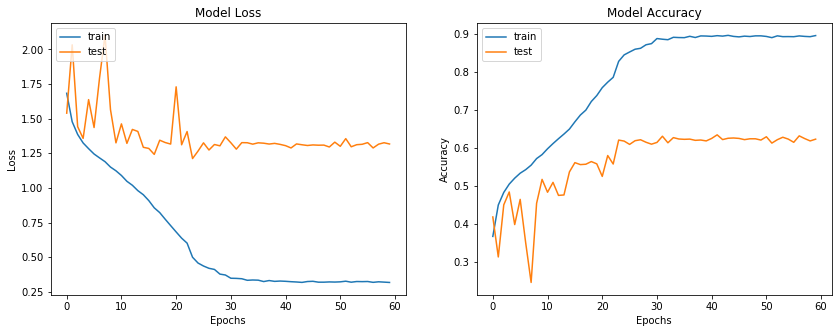

In [15]:
"""
lets plot 
"""
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model evaluation

In [16]:
training_set.reset()
test_set.reset()

train_steps = training_set.samples // training_set.batch_size
test_steps = test_set.samples // test_set.batch_size

train_loss, train_acc = model.evaluate_generator(training_set, steps=train_steps)
test_loss, test_acc   = model.evaluate_generator(test_set, steps=test_steps)
print("final train accuracy = {:.2f} , testing accuracy = {:.2f}".format(train_acc*100, test_acc*100))


final train accuracy = 92.17 , testing accuracy = 60.85


In [17]:
model.save_weights('facial_expressions_bestweight.h5')

## Model Prediction

(48, 48)


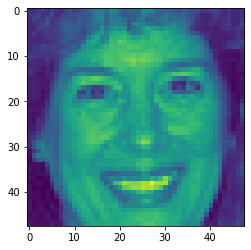

In [18]:
img = image.load_img(test_dir+"happy/PrivateTest_1735299.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) 

In [19]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [20]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [21]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Happy


## Confusion Matrix and Classification on training set

Confusion Matrix
[[ 435   59  462  804  578  521  337]
 [  41    3   47   92   48   73   45]
 [ 435   40  469  836  602  542  354]
 [ 826   81  758 1508 1033  913  653]
 [ 518   64  573 1013  685  659  460]
 [ 566   52  531  924  719  677  395]
 [ 344   34  331  649  440  456  283]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3196
     disgust       0.01      0.01      0.01       349
        fear       0.15      0.14      0.15      3278
       happy       0.26      0.26      0.26      5772
     neutral       0.17      0.17      0.17      3972
         sad       0.18      0.18      0.18      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.18     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.18      0.18      0.18     22968



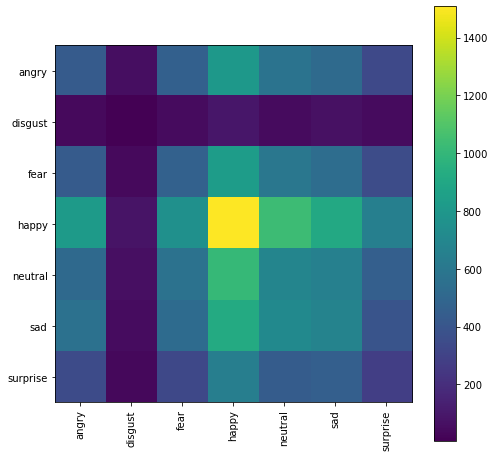

In [22]:
training_set.reset()
train_steps = (training_set.samples // training_set.batch_size)+1

y_pred = model.predict_generator(training_set, steps=train_steps)
y_pred = np.argmax(y_pred, axis=1)
class_labels = training_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Confusion Matrix and Classification on test set

Confusion Matrix
[[112  10  97 188 149 138 105]
 [  4   0  13  18  23  17  12]
 [102   4 113 212 170 137  81]
 [204  13 182 394 246 238 166]
 [122   9 120 274 164 179 125]
 [131   9 120 245 180 183  98]
 [100  10  64 164 115 121  60]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14       799
     disgust       0.00      0.00      0.00        87
        fear       0.16      0.14      0.15       819
       happy       0.26      0.27      0.27      1443
     neutral       0.16      0.17      0.16       993
         sad       0.18      0.19      0.18       966
    surprise       0.09      0.09      0.09       634

    accuracy                           0.18      5741
   macro avg       0.14      0.14      0.14      5741
weighted avg       0.18      0.18      0.18      5741



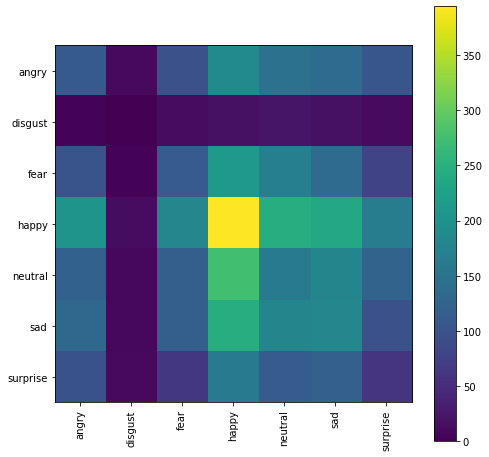

In [23]:
test_set.reset()
test_steps = (test_set.samples // test_set.batch_size)+1

y_pred = model.predict_generator(test_set, steps=test_steps)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)